In [86]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import scipy.optimize
import pymc3 as pm
import arviz as az
import theano.tensor as tt
from inspect import signature
import warnings
warnings.simplefilter('ignore')

In [87]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()  # Nice plot aesthetic

# Utility models

In [88]:
def u_pow(x, theta): return x**theta[0]

In [89]:
def u_exp(x, theta): return 1 - np.exp(-theta[0]*x)

# Generate choice data

In [69]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=(0.5, )):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [70]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [90]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1:]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [91]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [92]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Model discrepancy

In [107]:
def build_model(u_m, data, seed=12345, max_n=100, theta=None, tau=None, x0=None):
    
    np.random.seed(seed)
    
    if tau is None or theta is None:
        opt_param = optimize(data=data, u_m=u_m, x0=x0)
        tau = opt_param[0]
        theta = opt_param[1:]
        print(f"Estimates: tau={tau}, theta={theta}")
    
    if len(data) > max_n:
        data = data.sample(n=max_n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values
    
    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    with pm.Model() as model:

        ρ = pm.InverseGamma('ρ', 2, 2)
        η = pm.HalfCauchy('η', 5)

        X = x_sorted.reshape(-1, 1)
        uX = u_m(X, theta)

        M = pm.gp.mean.Constant(uX.flatten())
        K = η**2 * pm.gp.cov.ExpQuad(1, ρ)  # If ratio: tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

        gp = pm.gp.Latent(mean_func=M, cov_func=K)
        f = gp.prior("f", X=X)

        est_eu =  p_sorted * f    
        est_eu_unsorted = est_eu[undo_sorted]
        n = len(y)
        diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])

        est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit(tau*diff_eu_hat))
        choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)
        
    return model, gp, x_sorted, tau, theta

In [108]:
def compute_r(samples, u_m, theta):
    return samples["f"] - u_m(x_sorted, theta)  # If ratio: pred_samples["f"]/u_m(x_sorted, theta)

# Measure discrepancy

In [109]:
u_data = u_pow
theta_data = (0.5, )
tau_data = 3.333
u_model = u_pow
theta_model = None
tau_model = None

In [110]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000)

In [111]:
model, gp, x_sorted, tau, theta = build_model(u_m=u_model, data=data, tau=tau_model, theta=theta_model)

with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Estimates: tau=3.2849649069856937, theta=[0.53506426]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 166 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8361325132815798, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [112]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

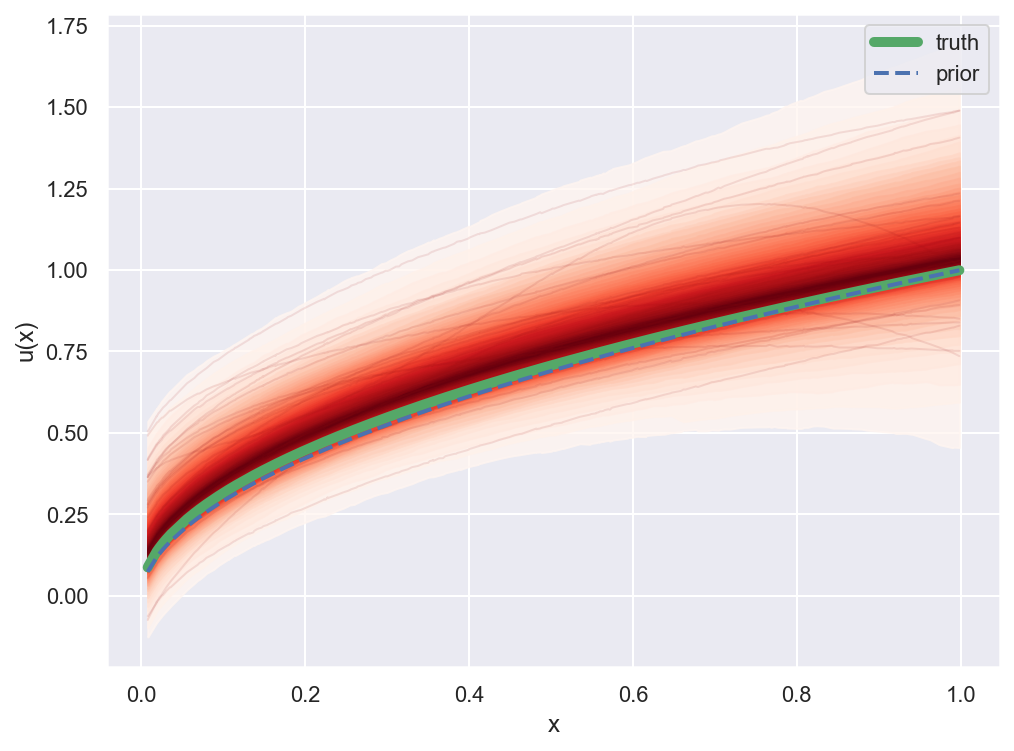

In [114]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_sorted, u_data(x_sorted, theta_data), lw=5, color='C2', label="truth")
ax.plot(x_sorted, u_model(x_sorted, theta), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

In [116]:
r = compute_r(samples=samples, u_m=u_model, theta=theta)

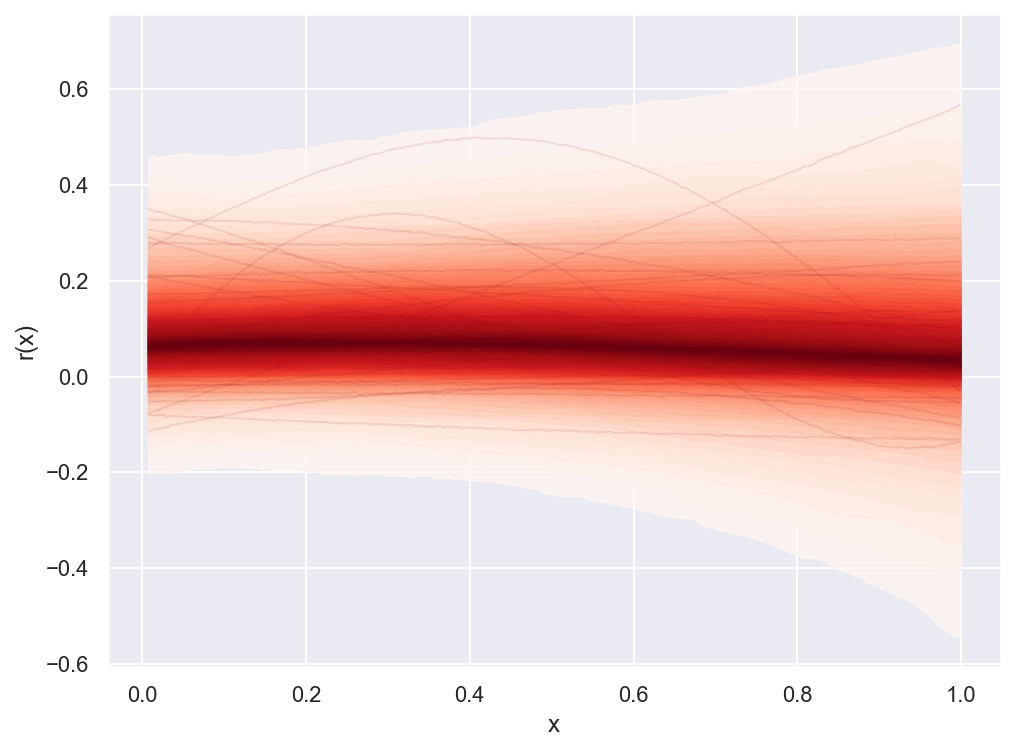

In [117]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_sorted.reshape(-1, 1))
ax.set_xlabel("x")
ax.set_ylabel("r(x)");

In [22]:
np.mean(r)

1.1282296079802618

In [23]:
np.mean(r**2)

1.361136999901593

# Wrong model

In [127]:
u_data = u_pow
theta_data = (0.5, )
tau_data = 3.333

u_model = u_exp
theta_model = (3.14, )
tau_model = 3.333

In [128]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, max_x=5)

In [129]:
model, gp, x_sorted, tau, theta = build_model(u_m=u_model, data=data, tau=tau_model, theta=theta_model)

with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 244 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [130]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

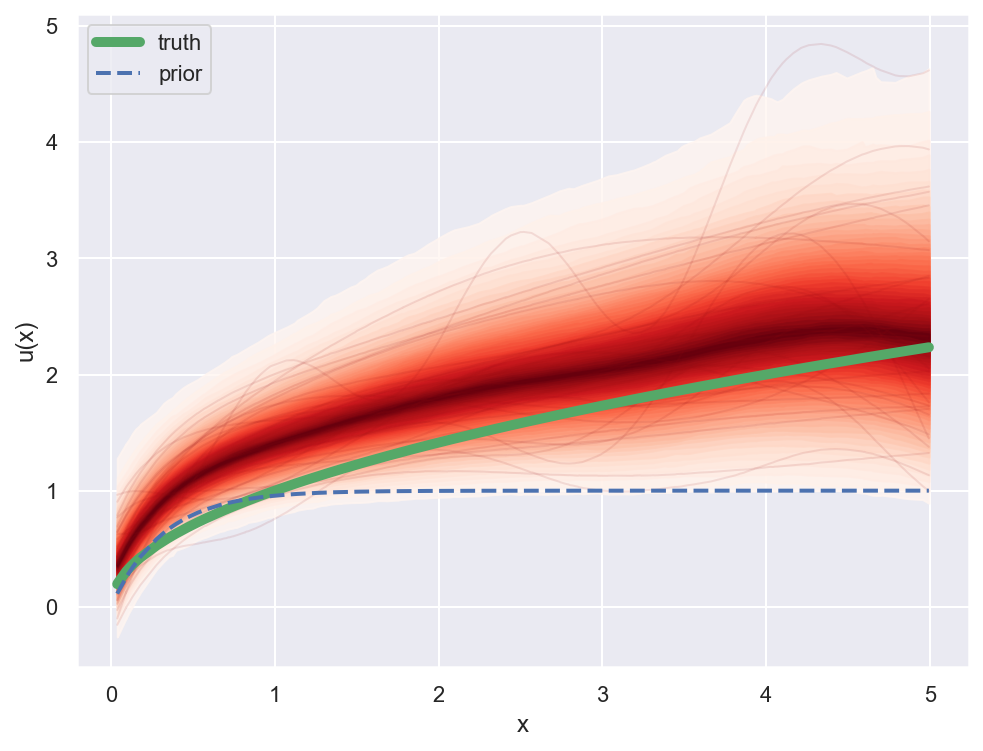

In [131]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_sorted, u_data(x_sorted, theta_data), lw=5, color='C2', label="truth")
ax.plot(x_sorted, u_model(x_sorted, theta), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

In [132]:
r = compute_r(samples=samples, u_m=u_model, theta=theta)

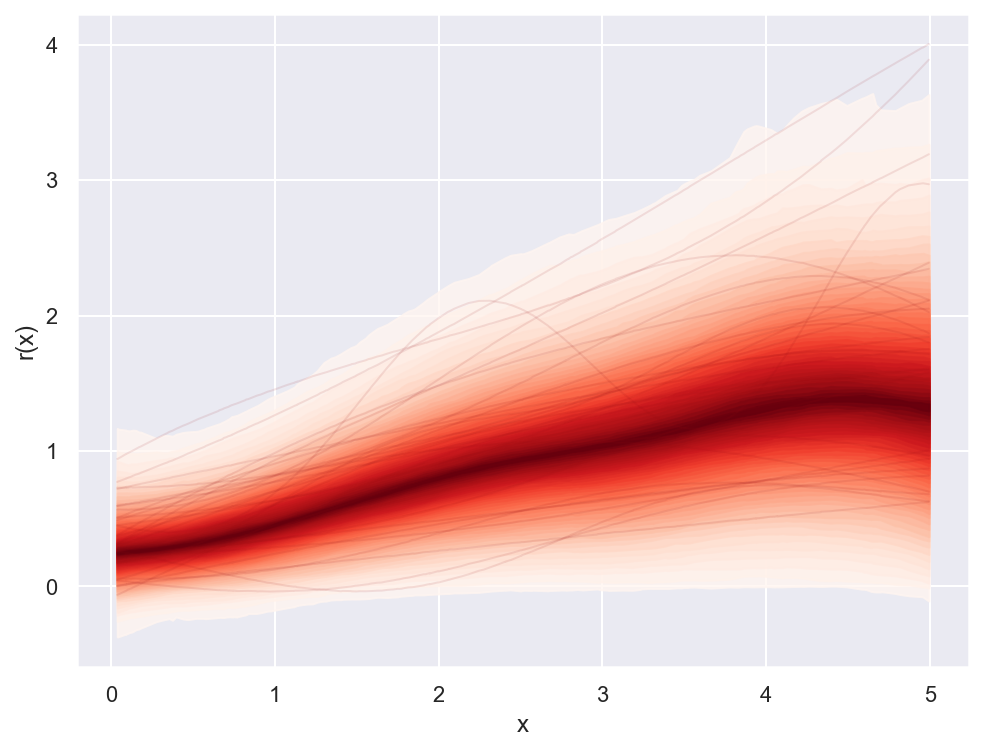

In [133]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_sorted.reshape(-1, 1))
ax.set_xlabel("x")
ax.set_ylabel("r(x)");

In [134]:
np.mean(r)

0.8863980567837505

In [135]:
np.mean(r**2)

1.2466831517064092